# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(26, 26)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df.sum(axis=0)

0     33.0
1     43.0
2     38.0
3     39.0
4     18.0
5     20.0
6     20.0
7     19.0
8      3.0
9      4.0
10     4.0
11     7.0
12     8.0
13     9.0
14     4.0
15     4.0
16     6.0
17     4.0
18     3.0
19     4.0
20     3.0
21     2.0
22     1.0
23     1.0
24     2.0
25     1.0
dtype: float64

In [7]:
np.where(agent_goods_df.loc[31] == 1)

(array([12]),)

In [8]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [9]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [10]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [11]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [12]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [13]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [14]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [15]:
#production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [16]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
-1,2758524.0,3.455911e+07
0,524442.0,3.174622e+06
1,891622.0,7.789899e+06
2,523227.0,1.186045e+07
3,554454.0,1.186484e+07
4,510080.0,5.100635e+06
5,860544.0,3.699116e+07
6,506519.0,2.078725e+07
7,525520.0,1.754237e+07


Text(0.5, 1.0, 'transaction count by tick')

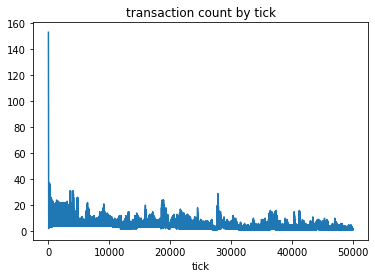

In [17]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

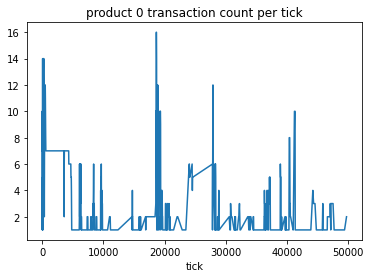

In [18]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

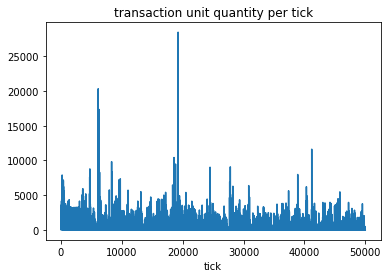

In [19]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

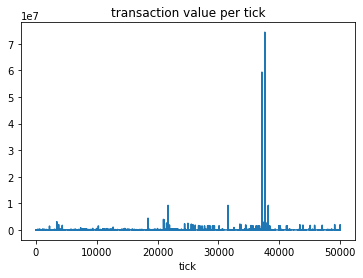

In [20]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

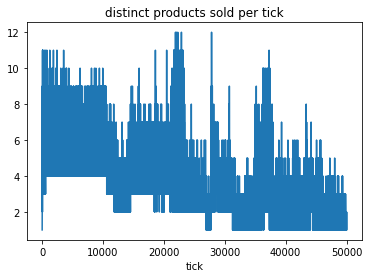

In [21]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

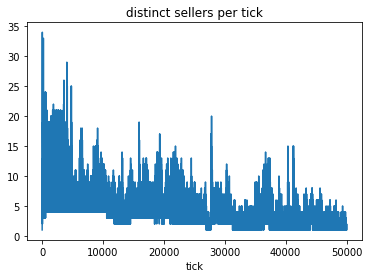

In [22]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

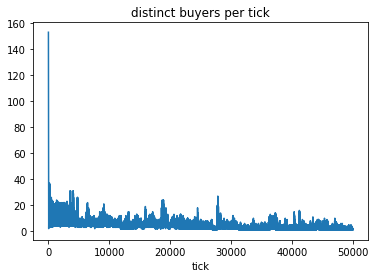

In [23]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [24]:
transaction_df["seller"].nunique()

301

In [25]:
transaction_df["buyer"].nunique()

301

In [26]:
transaction_df["product"].nunique()

27

<AxesSubplot:>

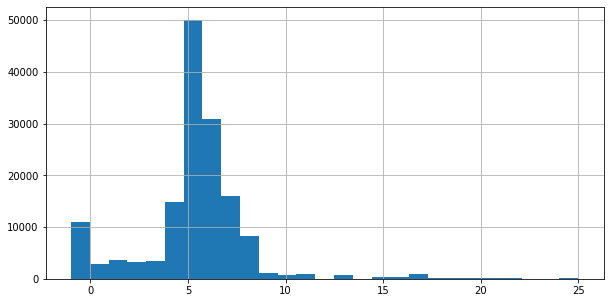

In [27]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

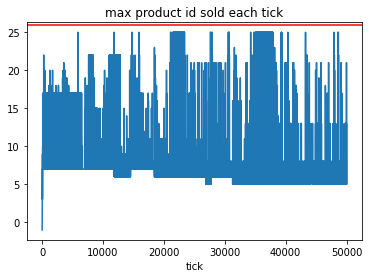

In [28]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [29]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    96.000000
mean     21.407791
std       1.973529
min      14.029356
25%      21.537778
50%      21.826081
75%      22.446729
max      23.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

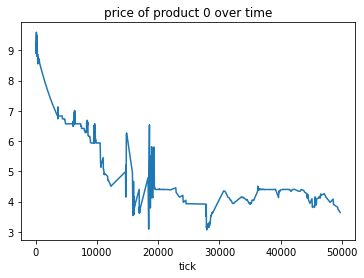

In [30]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean().plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 3 over time')

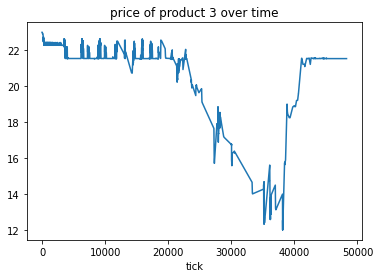

In [31]:
transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean().plot()
plt.title("price of product 3 over time")

<AxesSubplot:>

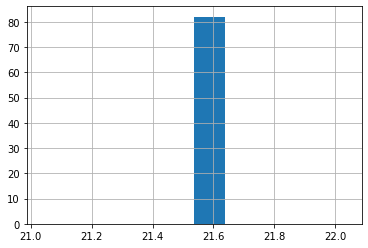

In [32]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

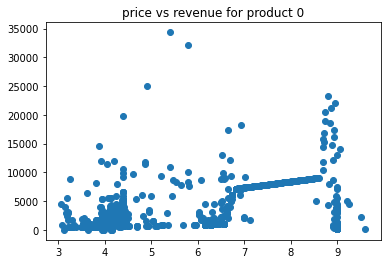

In [33]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

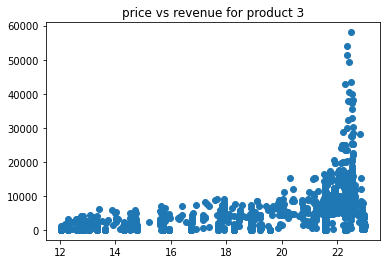

In [34]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [35]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value


In [36]:
transaction_df.groupby("product").agg({"tick":"max", "price":"mean", "amount":"sum", "value":"sum"})

,tick,price,amount,value
product,,,,
-1,49977,1.496642e+01,2758524.0,3.455911e+07
0,49701,6.347390e+00,524442.0,3.174622e+06
1,49976,8.675806e+00,891622.0,7.789899e+06
2,48076,2.270522e+01,523227.0,1.186045e+07
3,48279,2.085356e+01,554454.0,1.186484e+07
4,49276,1.030534e+01,510080.0,5.100635e+06
5,50000,4.409115e+01,860544.0,3.699116e+07
6,47127,4.478448e+01,506519.0,2.078725e+07
7,48526,4.053658e+01,525520.0,1.754237e+07


## Transaction Graph

### By Agent

In [37]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,-1,23,4.0
1,-1,24,1.0
2,-1,25,138.0
3,-1,202,1.0
4,0,-1,18129.0
...,...,...,...
4079,298,276,263.0
4080,298,281,203.0
4081,298,282,262.0
4082,298,284,150.0


In [38]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [39]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [40]:
G = nx.relabel_nodes(G, labels)

In [41]:
nx.is_directed_acyclic_graph(G)

False

In [42]:
# this is pretty slow for lots of agents
#plt.figure(figsize=(15, 15))
#pos = graphviz_layout(G, prog='dot')
#nx.draw(G, pos, with_labels=True, arrows=True)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()

### By Good

In [43]:
augmented_transaction_df = transaction_df.merge(agent_goods_df.idxmax(axis=1).rename("buyer_product"), how="left", left_on="buyer", right_index=True)
augmented_transaction_df["buyer_product"].fillna(-2, inplace=True)
product_flow = augmented_transaction_df.groupby(["product", "buyer_product"])["value"].sum().to_frame().reset_index().rename({"buyer_product":"target", "product":"source", "amount":"value"}, axis=1)

In [44]:
agent_goods_df.columns

RangeIndex(start=0, stop=26, step=1)

In [45]:
set(agent_goods_df.columns) - set(product_flow["source"].unique())

set()

In [46]:
set(agent_goods_df.columns) - set(product_flow["target"].unique())

set()

In [47]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
sankey = SankeyWidget(layout=Layout(height='680', width='1024'), links=product_flow.to_dict("records"))
sankey

SankeyWidget(layout=Layout(height='680', width='1024'), links=[{'source': -1, 'target': 0.0, 'value': 2885833.…

In [48]:
help(SankeyWidget)

Help on class SankeyWidget in module ipysankeywidget.sankey_widget:

class SankeyWidget(ipywidgets.widgets.domwidget.DOMWidget)
 |  SankeyWidget(**kwargs)
 |  
 |  Sankey widget
 |  
 |  Method resolution order:
 |      SankeyWidget
 |      ipywidgets.widgets.domwidget.DOMWidget
 |      ipywidgets.widgets.widget.Widget
 |      ipywidgets.widgets.widget.LoggingHasTraits
 |      traitlets.traitlets.HasTraits
 |      traitlets.traitlets.HasDescriptors
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Constructor
 |  
 |  auto_save_png(self, filename)
 |      Save the diagram to a PNG file, once it has been rendered.
 |      
 |      This waits for the diagram to be rendered, then automatically calls
 |      `save_png` for you.
 |      
 |      Parameters
 |      ----------
 |      filename : string
 |  
 |  auto_save_svg(self, filename)
 |      Save the diagram to an SVG file, once it has been rendered.
 |      
 |      This waits for the dia

In [49]:
from IPython.display import (
    Image,
    SVG
)
import base64
data = base64.decodebytes(bytes(sankey.png, 'ascii'))
Image(data)

## Indicators by Market

In [50]:
transactions_by_product = pd.DataFrame({"producers":agent_goods_df.sum(axis=0), "sellers":transaction_df.groupby("product")["seller"].nunique()})
transactions_by_product["zero_sales"] = transactions_by_product["producers"] - transactions_by_product["sellers"]
transactions_by_product["seller_value_cv"] = transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").std() / transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").mean()
transactions_by_product["transactions"] = transaction_df.groupby("product")["price"].count()
transactions_by_product["total_value"] = transaction_df.groupby("product")["value"].sum()
transactions_by_product["price"] = transaction_df.groupby("product")["price"].mean()
transactions_by_product["price_cv"] = transaction_df.groupby("product")["price"].std() / transaction_df.groupby("product")["price"].mean()
transactions_by_product["first_tick"] = transaction_df.groupby("product")["tick"].min()
transactions_by_product["last_tick"] = transaction_df.groupby("product")["tick"].max()

transactions_by_product

,producers,sellers,zero_sales,seller_value_cv,transactions,total_value,price,price_cv,first_tick,last_tick
-1,NaN,1,NaN,NaN,11021,3.455911e+07,1.496642e+01,0.512612,0,49977
0,33.0,33,0.0,0.149490,2900,3.174622e+06,6.347390e+00,0.272820,26,49701
1,43.0,43,0.0,0.157104,3566,7.789899e+06,8.675806e+00,0.135555,26,49976
2,38.0,38,0.0,0.148547,3153,1.186045e+07,2.270522e+01,0.094176,26,48076
3,39.0,39,0.0,0.216578,3499,1.186484e+07,2.085356e+01,0.123401,26,48279
4,18.0,18,0.0,0.731243,14861,5.100635e+06,1.030534e+01,0.421058,27,49276
5,20.0,20,0.0,2.130967,50057,3.699116e+07,4.409115e+01,0.347254,27,50000
6,20.0,20,0.0,1.454095,30970,2.078725e+07,4.478448e+01,0.239174,27,47127
7,19.0,19,0.0,0.926012,16108,1.754237e+07,4.053658e+01,0.294728,27,48526
8,3.0,3,0.0,0.605497,8251,5.790151e+07,7.744548e+02,0.353006,71,49869


In [51]:
transaction_df[transaction_df["product"] == 4].groupby("seller")["amount"].sum()

seller
4      18257.0
38     51990.0
43     13471.0
54     45216.0
58     18360.0
61     20226.0
79     39228.0
99     52056.0
125    11352.0
136    36756.0
140    13866.0
149    37856.0
156    23418.0
158    18654.0
201    37740.0
226    16956.0
275    41616.0
279    13062.0
Name: amount, dtype: float64

# Balance

In [52]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,1306.022185
1,0,1573.269285
2,0,3379.634358
3,0,3234.629352
4,0,5100.000000
...,...,...
295,0,398400.000000
296,0,9000.000000
297,0,1573.269285


In [53]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,50000,11953.867155
1,50000,2086.592038
2,50000,21.918795
3,50000,18.343851
4,50000,26275.707367
...,...,...
295,50000,717483.749193
296,50000,752108.084162
297,50000,3796.998421


In [54]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [55]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    3.000000e+02
mean     1.433710e+07
std      1.614298e+08
min      1.306022e+03
25%      1.573269e+03
50%      3.379634e+03
75%      1.800000e+04
max      1.975291e+09
Name: balance, dtype: float64

In [56]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    3.000000e+02
mean     1.489385e+07
std      1.617010e+08
min      4.300530e-02
25%      1.991501e+01
50%      1.291692e+04
75%      2.910283e+05
max      1.985889e+09
Name: balance, dtype: float64

In [57]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

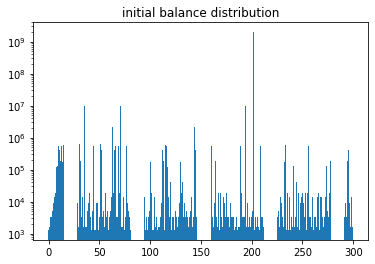

In [58]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

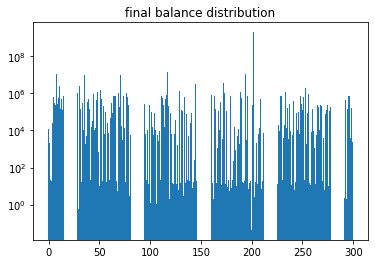

In [59]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [60]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0       10647.844971
1         513.322753
2       -3357.715563
3       -3216.285501
4       21175.707367
           ...      
295    319083.749193
296    743108.084162
297      2223.729136
298    149425.019493
299       846.287750
Name: balance, Length: 300, dtype: float64

<AxesSubplot:xlabel='agent'>

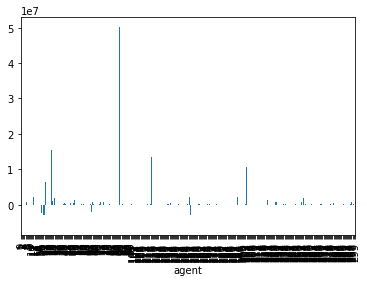

In [61]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]).plot.bar()

In [62]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0       11953.867155
1        2086.592038
2          21.918795
3          18.343851
4       26275.707367
           ...      
295    717483.749193
296    752108.084162
297      3796.998421
298    163225.019493
299      2419.557035
Name: balance, Length: 300, dtype: float64

In [63]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
600000,0,50000,1.195387e+04
600001,1,50000,2.086592e+03
600002,2,50000,2.191880e+01
600003,3,50000,1.834385e+01
600004,4,50000,2.627571e+04
600005,5,50000,6.742379e+05
600006,6,50000,2.914985e+05
600007,7,50000,2.436458e+05
600008,8,50000,1.070932e+07
600009,9,50000,2.810135e+05


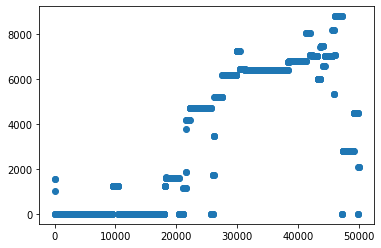

In [64]:
plt.scatter(balance_df[balance_df["agent"] == 1]["tick"],balance_df[balance_df["agent"] == 1]["balance"])

In [65]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [66]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,9.152882
1,1.326278
2,0.006486
3,0.005671
4,5.152099
...,...
295,1.800913
296,83.567565
297,2.413445


# Inventory

## Last Tick Inventory

In [67]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,16,17,18,19,20,21,22,23,24,25
600000,0,50000,3782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600001,1,50000,0.0,3580.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600002,2,50000,0.0,0.0,724.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600003,3,50000,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600004,4,50000,0.0,0.0,0.0,0.0,757.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600295,295,50000,0.0,0.0,0.0,0.0,0.0,0.0,800.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600296,296,50000,0.0,4.0,0.0,0.0,0.0,1602.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600297,297,50000,0.0,3346.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600298,298,50000,0.0,0.0,0.0,0.0,0.0,0.0,1050.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [68]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
0,3782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,3580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,724.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,757.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,0.0,1602.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,3346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
298,0.0,0.0,0.0,0.0,0.0,0.0,1050.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [69]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,800.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [70]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,790.0,-3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [71]:
agent_id = 7
target_tick = np.inf

target_tick = np.clip(target_tick, 0, inventory_df["tick"].max())

inv_s = inventory_df[inventory_df["tick"] == target_tick].set_index("agent").loc[agent_id].drop("tick")
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,1.0,9.0,-9.0,0.0
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,NaN
7,1791.0,0.0,0.0,1791.0,inf
8,0.0,0.0,0.0,0.0,NaN
9,0.0,0.0,0.0,0.0,NaN


In [72]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == target_tick)]

,agent,tick,balance
600007,7,50000,243645.830212


In [73]:
buy_price_df[(buy_price_df["tick"] == target_tick) & (buy_price_df["agent"] == agent_id)].T

,600007
agent,7.000000
tick,50000.000000
0,0.000000
1,0.000000
2,0.000000
3,20.774398
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [74]:
buy_budget_df[(buy_budget_df["tick"] == target_tick) & (buy_budget_df["agent"] == agent_id)].T

,600007
agent,7.0
tick,50000.0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0


In [75]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count    2001.000000
mean     1332.314343
std       615.514266
min         0.000000
25%       936.000000
50%      1575.000000
75%      1784.000000
max      1791.000000
Name: 7, dtype: float64

# Buy and Sell Prices

In [76]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     3.521076e+00
1     7.673072e+00
2     1.421140e+01
3     1.814724e+01
4     3.431684e+00
5     7.681449e+00
6     1.245841e+01
7     1.402967e+01
8     5.484619e+02
9     4.204941e+00
10    5.203680e+01
11    4.257670e+01
12    6.967005e+01
13    3.005823e+02
14    1.529809e+01
15    3.057200e+01
16    1.815105e+02
17    2.431868e+02
18    1.370327e+03
19    7.708780e+03
20    2.707099e+03
21    7.622000e+03
22    3.525141e+03
23    9.220157e+06
24    5.930783e+07
25    2.604305e+05
dtype: float64

## Market Analysis for one Good

### Overview of one Market

In [77]:
product_id = 7
min_ticks = 0
max_ticks = np.inf

max_ticks = np.clip(max_ticks, 0, sell_price_df["tick"].max())

dfsp = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)

df1 = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df1_mean = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].mean().to_frame()
df1_max = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].max().to_frame()
dfms = dfms[dfms[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[(buy_budget_df[product_id] > 0) & buy_budget_df["tick"].between(min_ticks, max_ticks)][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["tick"].between(min_ticks, max_ticks) & inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


Seller prices

In [78]:
sell_price_df[(sell_price_df[product_id] < np.inf) & sell_price_df["tick"].between(min_ticks, max_ticks)].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
7,2001.0,20.086148,3.959177,12.466835,17.401779,21.294766,21.552231,40.0
40,2001.0,19.097978,4.949761,11.964396,14.029668,20.080518,22.509139,40.0
56,2001.0,20.604240,3.960545,11.502314,18.051424,21.505113,22.635086,40.0
64,2001.0,20.850173,3.738821,10.615773,19.071979,21.537065,22.272684,40.0
70,2001.0,20.117727,4.570124,9.451196,17.977236,21.538906,22.324364,40.0
101,2001.0,20.011048,4.821206,10.334400,17.431218,21.509066,22.277168,40.0
131,2001.0,20.713181,3.934308,12.198410,17.919380,21.537065,22.510012,40.0
167,2001.0,19.660068,4.891634,9.491828,16.903629,20.632128,22.503104,40.0
169,2001.0,20.280316,3.830066,12.182050,17.841661,21.487639,21.633492,40.0


Buyer Prices

In [79]:
buyer_df.groupby("agent")[f'{product_id}_price'].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,360.0,62.767858,12.684401,17.620015,53.438128,62.546158,75.199113,85.025848
11,898.0,30.439652,24.335119,1.219865,9.503893,22.221009,46.683795,94.628008
15,384.0,51.012262,20.039149,0.021798,44.658966,53.035721,63.308886,81.118260
17,400.0,52.244358,19.549751,0.027276,43.230065,51.151119,65.736739,88.363910
30,514.0,47.570966,26.456576,0.009725,18.508730,49.356907,69.671273,92.081558
51,404.0,46.620338,21.929802,0.037963,25.510108,47.472067,64.423528,85.473902
52,640.0,36.219847,27.533147,0.951427,9.047556,37.314242,58.964691,89.522286
65,956.0,29.598814,24.356023,0.012061,10.467395,17.014990,46.309225,94.196865
82,819.0,30.723770,18.494252,3.972173,13.171191,22.617415,47.673026,73.140863


#### Market Volume

32064.0


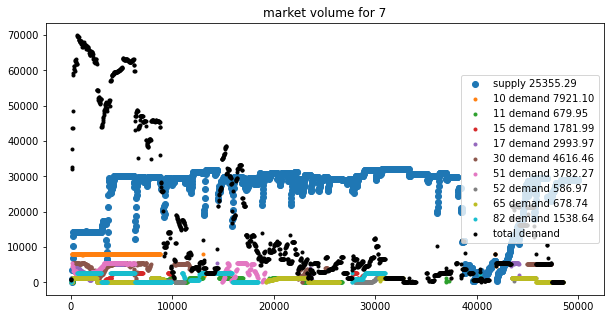

In [80]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

In [81]:
seller_df[seller_df > 0].index.to_series().describe()

count     1993.000000
mean     24995.195685
std      14416.225931
min         75.000000
25%      12525.000000
50%      24975.000000
75%      37425.000000
max      50000.000000
Name: tick, dtype: float64

In [82]:
seller_df.describe()

count     2001.000000
mean     25355.290355
std       8640.011024
min          0.000000
25%      25595.000000
50%      29331.000000
75%      30130.000000
max      32064.000000
Name: 7, dtype: float64

In [83]:
buyer_df.groupby("agent")["units"].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,360.0,7921.102778,864.546325,108.0,8010.00,8019.0,8037.0,8100.0
11,898.0,679.948775,632.134867,15.0,17.00,696.0,1347.0,1350.0
15,384.0,1781.986979,1134.216078,18.0,666.00,2682.0,2682.0,2700.0
17,400.0,2993.975000,2237.325760,18.0,193.75,3258.0,5346.0,5400.0
30,514.0,4616.459144,1185.310489,25.0,4073.50,5332.0,5349.0,5400.0
51,404.0,3782.272277,1676.088737,3.0,2359.00,4042.0,5383.0,5400.0
52,640.0,586.971875,595.845168,17.0,17.00,201.0,1336.0,1350.0
65,956.0,678.735356,645.964520,14.0,18.00,701.0,1346.0,1350.0
82,819.0,1538.641026,1242.166936,17.0,27.00,2681.0,2691.0,2700.0


In [84]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,2001.0,85.232384,342.501728,0.0,0.0,0.0,0.0,2500.0
11,2001.0,1184.145427,2040.800718,0.0,0.0,0.0,1700.0,7600.0
15,2001.0,309.670165,1018.354465,0.0,0.0,0.0,0.0,5525.0
17,2001.0,506.446777,1463.622746,0.0,0.0,0.0,0.0,7100.0
30,2001.0,62.893553,301.578013,0.0,0.0,0.0,0.0,2400.0
51,2001.0,200.112444,691.749810,0.0,0.0,0.0,0.0,4200.0
52,2001.0,725.799600,1652.846404,0.0,0.0,0.0,400.0,7725.0
65,2001.0,1167.766117,2068.060645,0.0,0.0,0.0,1550.0,7725.0
82,2001.0,548.150925,1381.634116,0.0,0.0,0.0,0.0,6700.0


In [85]:
df2[product_id].max()

98.58961551988077

In [86]:
df2.groupby("tick")[product_id].describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,2001.0,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,19.0,21.399854,11.592934,5.252998,11.982803,19.797243,29.553889,41.674729
std,0.0,18.774323,6.642567,12.975151,19.415813,20.456641,20.714690,25.663294
min,19.0,8.832932,2.472048,0.009725,0.043717,0.569328,15.264726,21.082219
25%,19.0,11.185107,7.359225,0.028671,1.026698,9.738532,15.773593,26.130280
50%,19.0,12.188901,8.920183,0.854779,3.968461,11.525447,19.697754,30.233712
75%,19.0,18.370294,12.870052,1.216331,7.324626,13.832801,29.946475,56.570121
max,19.0,72.343111,33.035051,47.673026,66.690737,83.475148,90.548010,98.589616


#### Market Price

is there a transaction?
do the sellers have inventory?
do any buyers demand goods?
are prices compatible?
is at least one agent in the cannot buy state (> 100 ticks)


Text(0.5, 1.0, 'price chart for 7')

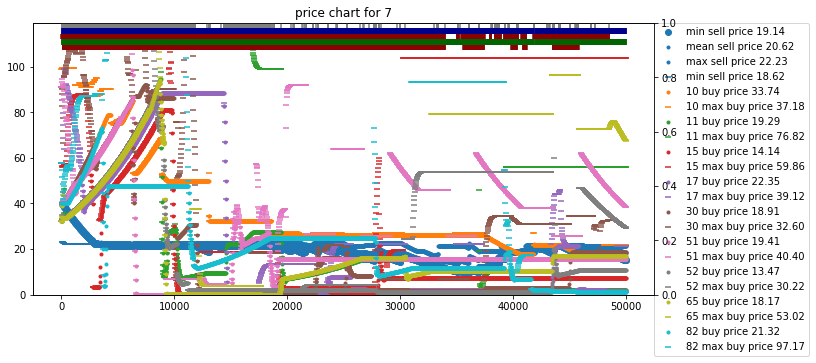

In [87]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1.index, df1[product_id], label=f'min sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(df1_mean.index, df1_mean[product_id], label=f'mean sell price {df1_mean[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(df1_mean.index, df1_max[product_id], label=f'max sell price {df1_max[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(dfms.index, dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
if len(df2) > 0:
    plt.ylim(0, df2[product_id].max()*1.1)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
print("is there a transaction?")
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
print("do the sellers have inventory?")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
print("do any buyers demand goods?")
ax2.vlines(buyer_df["tick"].unique()[(buyer_df.groupby("tick")["units"].sum() > 0)], ymin=0.94, ymax=0.96, color="darkred")
print("are prices compatible?")
price_diff = (df2.groupby("tick")[product_id].max() - df1[product_id]).rename("price_diff")
ax2.vlines(df1.join(price_diff[price_diff>0]).index, ymin=0.92, ymax=0.94, color="darkgreen")
print("is at least one agent in the cannot buy state (> 100 ticks)")
ax2.vlines(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)]["tick"].unique()[(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)].groupby("tick")[product_id].max() > 100)], ymin=0.90, ymax=0.92, color="darkred")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



In [88]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
228,27,7,189,283,40.100000,9.0,360.900000
285,28,7,30,235,40.100000,9.0,360.900000
317,29,7,17,255,40.100000,9.0,360.900000
325,30,7,256,277,40.100000,9.0,360.900000
329,31,7,233,64,40.100000,9.0,360.900000
...,...,...,...,...,...,...,...
146207,46903,7,221,253,19.812402,1575.0,31204.533859
146209,46904,7,221,70,19.812690,209.0,4140.852278
146727,47251,7,30,190,18.493891,1575.0,29127.878713
146846,47301,7,30,7,18.567139,1791.0,33253.745800


#### Ticks when max buy price changes a lot

In [89]:
def consecutive_diffs(x):
    return x.iloc[1] - x.iloc[0]
    print(x)
    raise Exception(x.__class__)
mb_diffs = dfmb.set_index("tick").groupby("agent")[product_id].rolling(2).apply(consecutive_diffs)
mb_diffs.to_frame().sort_values(["agent", product_id], key=abs, ascending=False).groupby("agent").head(5)

7
agent tick            
295   27250  72.054641
      7900   49.730049
      27275 -36.933227
      33075  36.273993
      11225  24.068761
...                ...
10    6350  -31.741429
      13075 -18.762130
      8875  -15.976268
      4400  -14.882817
      41800   9.307264

[95 rows x 1 columns]

#### Balance

(0.0, 3134710.025759598)

<Figure size 432x288 with 0 Axes>

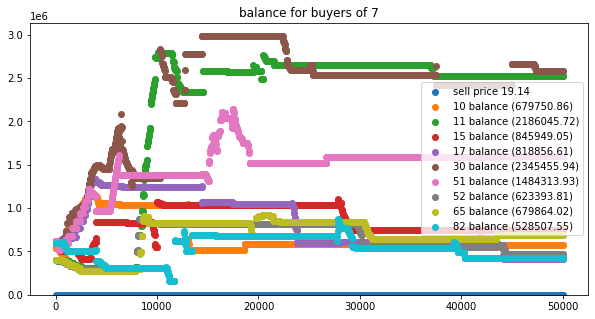

In [90]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [91]:
np.where(agent_goods_df[product_id])

(array([  7,  40,  56,  64,  70, 101, 131, 167, 169, 175, 190, 235, 246,
        250, 253, 255, 266, 277, 283]),)

(0.0, 762355.0190819962)

<Figure size 432x288 with 0 Axes>

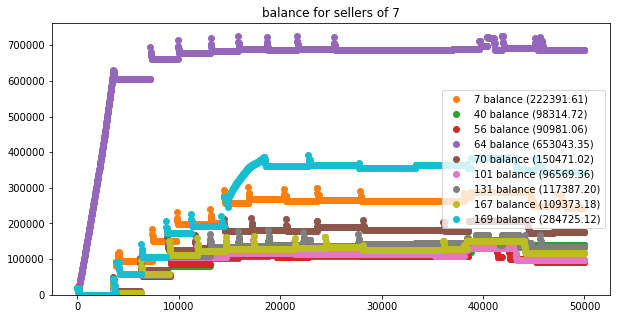

In [92]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
#plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(np.where(agent_goods_df[product_id])[0], colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for sellers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

### Sellers for the Market

In [93]:
np.where(agent_goods_df[product_id] == 1)

(array([  7,  40,  56,  64,  70, 101, 131, 167, 169, 175, 190, 235, 246,
        250, 253, 255, 266, 277, 283]),)

Amounts Sold

In [94]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["amount"].sum()

seller
7      21483.0
40     16398.0
56     16200.0
64     51552.0
70     17084.0
101    16650.0
131    20322.0
167    17199.0
169    50454.0
175    16244.0
190    43047.0
235    19602.0
246    15300.0
250    14364.0
253    89856.0
255    17685.0
266    18945.0
277    20583.0
283    42552.0
Name: amount, dtype: float64

Time ranges of sales

In [95]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
7,218.0,5162.770642,6092.799831,33.0,3825.25,3954.5,4033.75,47301.0
40,15.0,15480.733333,13628.112748,45.0,4891.00,13052.0,24988.50,38777.0
56,23.0,14186.478261,16025.063922,42.0,62.00,9126.0,25289.50,45078.0
64,1619.0,3840.765287,8237.997156,31.0,1300.50,2484.0,3223.50,45800.0
70,24.0,12506.625000,15702.813350,39.0,105.00,4827.0,21332.75,46904.0
101,19.0,18151.789474,15656.326498,44.0,4893.50,14651.0,30938.50,45601.0
131,25.0,29336.040000,17450.721567,34.0,13053.00,38426.0,45637.00,45643.0
167,40.0,33754.825000,15818.944060,36.0,23632.25,44055.5,44065.25,44075.0
169,3621.0,16648.117647,1481.016569,41.0,15723.00,16638.0,17549.00,45076.0


Prices for transactions

In [96]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
7,218.0,47.859445,6.556578,12.502613,48.783824,49.405712,49.548427,56.743064
40,15.0,32.070327,13.980282,13.786796,19.880384,34.379565,40.580051,53.620268
56,23.0,32.621932,11.863936,11.507574,20.608307,40.100000,40.200500,53.191372
64,1619.0,42.169889,4.928077,13.112484,40.454541,42.378039,45.179625,56.058087
70,24.0,34.775555,12.853810,13.822381,21.743504,40.480063,40.580051,58.273275
101,19.0,28.236897,14.021024,10.351989,17.019263,23.200340,40.100045,53.495981
131,25.0,27.754974,12.657730,12.985198,21.537314,21.555250,34.379930,53.914394
167,40.0,24.233293,9.955174,12.677798,21.033406,21.033406,21.578035,53.911092
169,3621.0,25.133226,1.828116,12.995942,23.895678,25.404183,26.114985,58.066163


Desired sell prices

In [97]:
sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
7,2001.0,20.086148,3.959177,12.466835,17.401779,21.294766,21.552231,40.0
40,2001.0,19.097978,4.949761,11.964396,14.029668,20.080518,22.509139,40.0
56,2001.0,20.604240,3.960545,11.502314,18.051424,21.505113,22.635086,40.0
64,2001.0,20.850173,3.738821,10.615773,19.071979,21.537065,22.272684,40.0
70,2001.0,20.117727,4.570124,9.451196,17.977236,21.538906,22.324364,40.0
101,2001.0,20.011048,4.821206,10.334400,17.431218,21.509066,22.277168,40.0
131,2001.0,20.713181,3.934308,12.198410,17.919380,21.537065,22.510012,40.0
167,2001.0,19.660068,4.891634,9.491828,16.903629,20.632128,22.503104,40.0
169,2001.0,20.280316,3.830066,12.182050,17.841661,21.487639,21.633492,40.0


Min Sell Prices

In [98]:
min_sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
7,2001.0,19.340034,3.169145,12.466835,17.401779,21.232012,21.552231,23.0
40,2001.0,18.533587,3.915009,11.964396,14.029668,19.781112,22.509139,23.0
56,2001.0,20.083885,2.839357,11.502314,18.051424,21.505113,22.635086,23.0
64,2001.0,20.343482,2.553593,10.615773,19.071979,21.537065,22.272684,23.0
70,2001.0,19.560003,3.637900,9.451196,17.855919,21.538906,22.324364,23.0
101,2001.0,19.299832,4.064393,10.334400,16.663074,21.446766,22.277168,23.0
131,2001.0,20.182075,2.791466,12.198410,17.919380,21.537065,22.510012,23.0
167,2001.0,19.078592,4.015502,9.491828,16.484253,20.357667,22.503104,23.0
169,2001.0,19.711722,2.655408,12.182050,17.841661,21.487639,21.633492,23.0


Product inventory

In [99]:
inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
7,2001.0,1332.314343,615.514266,0.0,936.0,1575.0,1784.0,1791.0
40,2001.0,1231.797601,739.502701,0.0,846.0,1728.0,1773.0,1809.0
56,2001.0,1404.841579,489.171933,0.0,1352.0,1584.0,1679.0,1791.0
64,2001.0,1461.418791,512.263773,0.0,1575.0,1584.0,1773.0,1791.0
70,2001.0,1284.419290,542.643125,0.0,1160.0,1575.0,1575.0,1782.0
101,2001.0,1382.015492,556.825819,0.0,1575.0,1609.0,1734.0,1791.0
131,2001.0,1460.370815,520.476666,0.0,1471.0,1755.0,1782.0,1791.0
167,2001.0,1342.939030,567.113252,0.0,1350.0,1584.0,1737.0,1775.0
169,2001.0,1212.833583,635.361524,0.0,945.0,1575.0,1584.0,1800.0


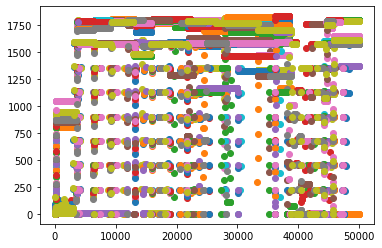

In [100]:
for agent in np.where(agent_goods_df[product_id])[0]:
    plt.scatter(inventory_df[inventory_df["agent"] == agent]["tick"], inventory_df[inventory_df["agent"] == agent][product_id])

Input inventory

In [101]:
production_needs = pd.Series(production_chain.adj_matrix[:,product_id] * production_chain.batch_sizes[product_id])
production_needs[production_needs > 0].to_frame()

,0
3,9.0


In [102]:
production_needs[production_needs > 0].index.to_list()

[3]

In [103]:
input_ids = production_needs[production_needs > 0].index.to_list()
inventory_melt = pd.melt(inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["agent", "tick"]+input_ids], id_vars=["agent", "tick"], value_vars=input_ids, var_name="product")
input_inventory_info = inventory_melt.groupby(["agent", "product"])["value"].describe()
input_inventory_info

,,count,mean,std,min,25%,50%,75%,max
agent,product,,,,,,,,
7,3,2001.0,17.881559,83.382297,0.0,0.0,0.0,1.0,613.0
40,3,2001.0,14.493253,77.698089,0.0,0.0,0.0,1.0,619.0
56,3,2001.0,15.002999,75.012219,0.0,0.0,1.0,2.0,523.0
64,3,2001.0,50.961519,138.824533,0.0,0.0,0.0,7.0,549.0
70,3,2001.0,18.116442,77.914446,0.0,1.0,4.0,7.0,644.0
101,3,2001.0,17.165917,76.574738,0.0,1.0,1.0,7.0,573.0
131,3,2001.0,18.159420,85.006877,0.0,0.0,0.0,4.0,588.0
167,3,2001.0,16.476762,78.757740,0.0,0.0,0.0,3.0,619.0
169,3,2001.0,48.953023,134.016386,0.0,0.0,1.0,8.0,530.0


In [104]:
inventory_melt.groupby(["agent","tick"])["value"].min().groupby("agent").describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
7,2001.0,17.881559,83.382297,0.0,0.0,0.0,1.0,613.0
40,2001.0,14.493253,77.698089,0.0,0.0,0.0,1.0,619.0
56,2001.0,15.002999,75.012219,0.0,0.0,1.0,2.0,523.0
64,2001.0,50.961519,138.824533,0.0,0.0,0.0,7.0,549.0
70,2001.0,18.116442,77.914446,0.0,1.0,4.0,7.0,644.0
101,2001.0,17.165917,76.574738,0.0,1.0,1.0,7.0,573.0
131,2001.0,18.159420,85.006877,0.0,0.0,0.0,4.0,588.0
167,2001.0,16.476762,78.757740,0.0,0.0,0.0,3.0,619.0
169,2001.0,48.953023,134.016386,0.0,0.0,1.0,8.0,530.0


Cannot sell ticks by seller

In [105]:
relevant_cannot_sell_df = cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["tick", "agent", product_id]]
relevant_cannot_sell_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
7,2001.0,1751.036982,2096.101259,0.0,100.0,1150.0,2400.0,9475.0
40,2001.0,1237.518741,1323.667992,0.0,0.0,825.0,2225.0,5000.0
56,2001.0,2449.675162,2436.234009,0.0,425.0,1800.0,3575.0,9825.0
64,2001.0,2961.244378,3420.559402,0.0,650.0,1825.0,3375.0,13950.0
70,2001.0,1616.704148,1670.253879,0.0,175.0,1200.0,2425.0,7350.0
101,2001.0,2545.702149,3328.612739,0.0,75.0,1375.0,2975.0,13350.0
131,2001.0,2052.861069,2216.907530,0.0,325.0,1425.0,2875.0,9850.0
167,2001.0,1642.553723,1743.793860,0.0,50.0,1225.0,2475.0,7500.0
169,2001.0,2361.694153,2475.739925,0.0,250.0,1600.0,3725.0,9750.0


Text(0.5, 1.0, 'cannot sell 7')

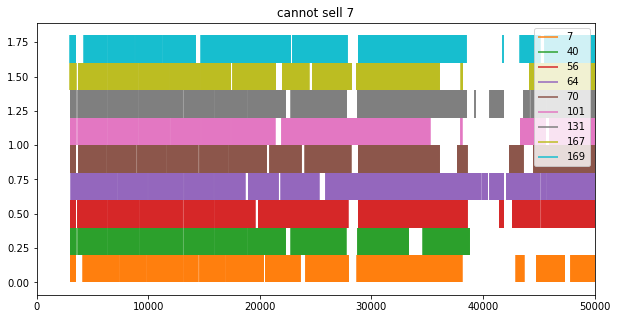

In [106]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_sell_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_sell_df[(relevant_cannot_sell_df["agent"] == agent) & (relevant_cannot_sell_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.xlim(min_ticks, max_ticks)
plt.title(f'cannot sell {product_id}')

### Buyers for the Market

Total Amount Purchased

In [107]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["amount"].sum()

buyer
10      40257.0
11       9228.0
15      11702.0
17      27720.0
30      52178.0
51      37451.0
52       3254.0
65       3996.0
82      14835.0
112      5364.0
115     22645.0
145      7236.0
151      9199.0
189     46801.0
221     72214.0
233      6876.0
256     44018.0
280    106712.0
295      3834.0
Name: amount, dtype: float64

Time Ranges of Purchase

In [108]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
10,1048.0,3373.308206,3419.320936,53.0,1932.75,3444.5,4206.25,41831.0
11,374.0,10561.088235,4043.279715,252.0,8489.25,10094.5,10187.75,37026.0
15,433.0,8596.930716,3538.794965,42.0,9556.00,9664.0,9772.00,28276.0
17,324.0,9281.358025,16515.567216,29.0,753.75,1284.5,1815.25,44152.0
30,2116.0,7122.912571,3472.821468,28.0,5649.75,6800.5,10257.25,47301.0
51,1926.0,12386.259086,6353.078178,40.0,5905.25,15638.5,17544.75,18426.0
52,177.0,9054.988701,3837.436755,126.0,8091.00,8385.0,9133.00,43651.0
65,133.0,9074.360902,4297.723633,126.0,8455.00,8563.0,8671.00,48526.0
82,319.0,11668.949843,4411.723991,54.0,10974.50,11054.0,11133.50,39627.0


Prices Paid

In [109]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
10,1048.0,45.623800,4.781561,20.577606,41.272359,46.806457,50.183279,53.284419
11,374.0,39.216477,16.011125,12.811070,24.332643,25.279268,56.234792,58.085499
15,433.0,48.411730,5.136374,17.701446,46.238438,51.330625,51.330625,51.330625
17,324.0,37.219884,8.199220,18.883356,40.179938,40.216891,40.810804,54.937298
30,2116.0,44.793249,12.076387,18.453588,26.055486,50.942170,54.354358,56.812274
51,1926.0,33.300746,11.921069,22.992846,23.667923,26.616770,49.644462,53.508446
52,177.0,45.995313,11.677809,19.851153,38.105882,52.722465,54.212982,55.532550
65,133.0,55.362539,6.267491,15.865643,56.027652,56.709905,57.402442,57.869927
82,319.0,34.143303,3.108024,16.620321,34.608008,34.608008,34.608008,47.679745


Desired Buy Prices

In [110]:
buy_price_df[buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,2001.0,33.736401,16.731339,15.619290,25.973734,26.155747,43.976704,85.025848
11,2001.0,19.288642,20.456014,1.219865,1.829798,15.609195,26.066201,94.628171
15,2001.0,14.136011,21.774945,0.021798,0.028671,7.412601,7.412601,81.118260
17,2001.0,22.353159,31.857908,0.027276,1.642974,2.234650,44.901832,88.364243
30,2001.0,18.912722,27.625267,0.009725,1.526997,3.099546,18.566788,92.081558
51,2001.0,19.406426,18.225622,0.037963,15.495110,15.495110,15.495110,98.589616
52,2001.0,13.466979,22.177809,0.951427,1.216331,1.992114,10.675973,89.522286
65,2001.0,18.165077,20.614917,0.012061,8.514357,10.344571,17.014990,94.196865
82,2001.0,21.316549,16.999584,1.117388,10.433138,16.074468,24.821107,73.141150


In [111]:
max_buy_price_df[max_buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,2001.0,37.182839,22.452268,15.619290,26.130280,26.927280,49.906444,99.496137
11,2001.0,76.816033,63.222119,1.219865,15.509134,55.977710,135.542614,230.668378
15,2001.0,59.863997,50.334305,0.021798,18.595919,60.845287,103.925038,331.128765
17,2001.0,39.124118,57.243260,0.027276,2.073184,13.378741,48.538720,188.427803
30,2001.0,32.600811,36.381147,0.009725,1.947295,21.345124,34.519593,159.324899
51,2001.0,40.401982,29.110064,0.037963,25.691025,37.970088,55.114259,207.033460
52,2001.0,30.219397,27.237970,0.951427,1.992116,32.638375,54.022407,144.241307
65,2001.0,53.021145,43.912388,0.012061,8.857501,59.514158,79.305014,160.264108
82,2001.0,97.170761,99.410725,1.117388,11.842447,87.877015,166.992943,338.880830


Cannot buy ticks by buyer

In [112]:
relevant_cannot_buy_df = cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id]>0)[0])][["tick", "agent", product_id]]
relevant_cannot_buy_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,2001.0,85.232384,342.501728,0.0,0.0,0.0,0.0,2500.0
11,2001.0,1184.145427,2040.800718,0.0,0.0,0.0,1700.0,7600.0
15,2001.0,309.670165,1018.354465,0.0,0.0,0.0,0.0,5525.0
17,2001.0,506.446777,1463.622746,0.0,0.0,0.0,0.0,7100.0
30,2001.0,62.893553,301.578013,0.0,0.0,0.0,0.0,2400.0
51,2001.0,200.112444,691.749810,0.0,0.0,0.0,0.0,4200.0
52,2001.0,725.799600,1652.846404,0.0,0.0,0.0,400.0,7725.0
65,2001.0,1167.766117,2068.060645,0.0,0.0,0.0,1550.0,7725.0
82,2001.0,548.150925,1381.634116,0.0,0.0,0.0,0.0,6700.0


Behavior of one buyer

In [113]:
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
price_diff[price_diff > 0].index

Int64Index([], dtype='int64', name='tick')

is transaction?
cannot buy?
has budget?
buy price at max price?
price compatible


Text(0.5, 1.0, 'behavior for buyer 10')

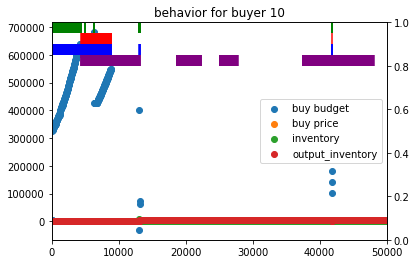

In [114]:
agent_id = relevant_cannot_buy_df["agent"].unique()[0]
agent_output = agent_goods_df.loc[agent_id].idxmax()
plt.scatter(buy_budget_df[buy_budget_df["agent"] == agent_id]["tick"], buy_budget_df[buy_budget_df["agent"] == agent_id][product_id], label=f'buy budget')
plt.scatter(buy_price_df[buy_price_df["agent"] == agent_id]["tick"], buy_price_df[buy_price_df["agent"] == agent_id][product_id], label=f'buy price')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][product_id], label=f'inventory')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][agent_output], label=f'output_inventory')
plt.legend(loc="right")
ax2 = plt.twinx()

print("is transaction?")
ax2.vlines(transaction_df[(transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]["tick"], ymin=0.95, ymax=1.0, color="green")
print("cannot buy?")
ax2.vlines(cannot_buy_df[(cannot_buy_df["agent"] == agent_id) & (cannot_buy_df[product_id] > 0)]["tick"], ymin=0.90, ymax=0.95, color="red")
print("has budget?")
ax2.vlines(buy_budget_df[(buy_budget_df["agent"] == agent_id) & (buy_budget_df[product_id] > 0)]["tick"], ymin=0.85, ymax=0.90, color="blue")
print("buy price at max price?")
ax2.vlines(buy_price_df[(buy_price_df["agent"] == agent_id) & (max_buy_price_df[product_id] - buy_price_df[product_id] < econ_sim.PRICE_EPS)]["tick"], ymin=0.80, ymax=0.85, color="purple")
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
print("price compatible")
ax2.vlines(price_diff[price_diff > 0].index, ymin=0.75, ymax=0.80, color="yellow")
ax2.set_ylim(0,1)

plt.xlim(min_ticks, max_ticks)

plt.title(f'behavior for buyer {agent_id}')

In [115]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
410,53,7,10,56,40.200500,9.0,361.804500
446,56,7,10,235,40.200500,9.0,361.804500
483,59,7,10,64,40.200500,63.0,2532.631500
499,60,7,10,64,40.200500,9.0,361.804500
512,61,7,10,255,40.200500,18.0,723.609000
...,...,...,...,...,...,...,...
137475,41827,7,10,169,20.670590,9.0,186.035307
137477,41828,7,10,283,20.743556,1350.0,28003.799947
137479,41829,7,10,131,21.495343,1350.0,29018.713692
137481,41830,7,10,56,21.618075,1350.0,29184.401704


<AxesSubplot:xlabel='tick'>

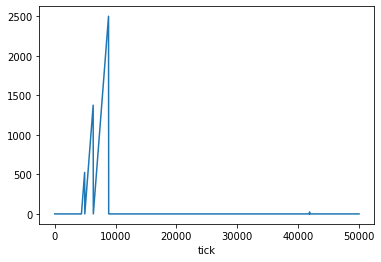

In [116]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & (cannot_buy_df["agent"] == agent_id)].set_index("tick")[product_id].plot()

When cannot buy exceeds 0

In [117]:
relevant_cannot_buy_df[relevant_cannot_buy_df[product_id] > 0].groupby("agent")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,177.0,6847.740113,2943.265952,4425.0,5550.00,6675.0,7775.00,41875.0
11,752.0,12705.751330,8833.689145,25.0,4743.75,10787.5,22006.25,26700.0
15,250.0,7951.400000,6308.615741,2600.0,4881.25,6437.5,7993.75,28800.0
17,299.0,6301.421405,4457.757555,1850.0,3712.50,5575.0,7437.50,23825.0
30,146.0,8690.753425,7778.390720,2875.0,3781.25,4687.5,7793.75,23275.0
51,254.0,7745.767717,6423.836563,1150.0,2731.25,4312.5,15918.75,19125.0
52,602.0,14668.147841,15030.150708,25.0,3806.25,7562.5,28643.75,45825.0
65,711.0,15390.963432,10972.443561,25.0,4487.50,19950.0,24387.50,32750.0
82,415.0,20817.168675,8262.327863,11750.0,14337.50,16925.0,29012.50,40350.0


(0.0, 50000.0)

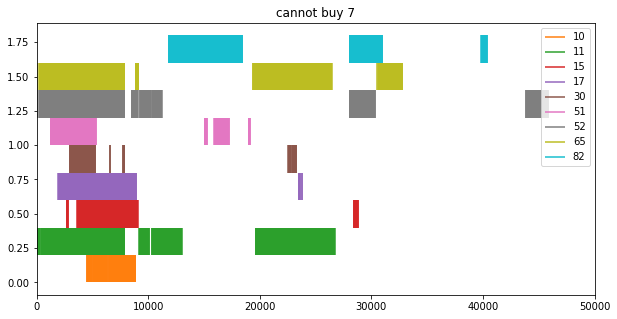

In [118]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_buy_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_buy_df[(relevant_cannot_buy_df["agent"] == agent) & (relevant_cannot_buy_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.title(f'cannot buy {product_id}')
plt.xlim(min_ticks, max_ticks)

## Buy/Sell Price Investigation

In [119]:
df1[product_id].describe()

count    1993.000000
mean       19.139013
std         4.544941
min         9.451196
25%        16.386900
50%        19.796364
75%        21.537778
max        40.000000
Name: 7, dtype: float64

In [120]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
10,2001.0,33.736401,16.731339,15.619290,25.973734,26.155747,43.976704,85.025848
11,2001.0,19.288642,20.456014,1.219865,1.829798,15.609195,26.066201,94.628171
15,2001.0,14.136011,21.774945,0.021798,0.028671,7.412601,7.412601,81.118260
17,2001.0,22.353159,31.857908,0.027276,1.642974,2.234650,44.901832,88.364243
30,2001.0,18.912722,27.625267,0.009725,1.526997,3.099546,18.566788,92.081558
51,2001.0,19.406426,18.225622,0.037963,15.495110,15.495110,15.495110,98.589616
52,2001.0,13.466979,22.177809,0.951427,1.216331,1.992114,10.675973,89.522286
65,2001.0,18.165077,20.614917,0.012061,8.514357,10.344571,17.014990,94.196865
82,2001.0,21.316549,16.999584,1.117388,10.433138,16.074468,24.821107,73.141150


In [121]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

6.569188767321112

In [122]:
(df2.groupby("tick")[product_id].max() - df1[product_id]).describe()

count    1993.000000
mean       22.587511
std        24.163904
min        -0.164017
25%         9.006221
50%        11.129978
75%        30.212229
max        77.085729
Name: 7, dtype: float64

In [123]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

126.0067553222002

In [124]:
(dfmb.groupby("tick")[product_id].max() - dfms[product_id]).describe()

count    1993.000000
mean      155.432120
std        67.266682
min        65.604331
25%       122.233613
50%       129.392762
75%       166.884804
max       837.690808
Name: 7, dtype: float64

In [125]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
7,23.000000,40.000000,40.000000,23.000000,17.000000
307,23.115000,40.000000,40.000000,23.000000,16.885000
607,23.116881,40.099939,40.000000,23.000000,16.883119
907,23.143457,40.100078,40.000000,22.943745,16.856543
1207,23.259174,40.578386,39.800000,22.943745,16.540826
...,...,...,...,...,...
598807,21.025572,21.025572,21.025572,21.025572,0.000000
599107,20.962495,20.962495,20.962495,20.962495,0.000000
599407,20.899607,20.899607,20.899607,20.899607,0.000000
599707,20.836909,20.836909,20.836909,20.836909,0.000000


## Larger Scale Market Analysis

In [126]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

In [127]:
demand_units_df.shape

(600300, 26)

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [128]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

product
-1     55.17048
 0     10.48884
 1     17.83244
 2     10.46454
 3     11.08908
 4     10.20160
 5     17.21088
 6     10.13038
 7     10.51040
 8      1.51488
 9      0.71140
 10     0.84420
 11     0.21612
 12     0.20590
 13     0.36030
 14     0.09806
 15     0.21456
 16     0.13604
 17     0.37742
 18     0.02372
 19     0.02910
 20     0.02002
 21     0.05200
 22     0.08860
 23     0.00008
 24     0.00004
 25     0.00276
Name: amount, dtype: float64

In [129]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "agents": agent_goods_df.sum(axis=0),
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

,agents,supply,supply_cv,demand,demand_cv,surplus,min_input_surplus
0,33.0,114733.116442,3.004218,1005.741129,1.561589,113727.375312,0.000000
1,43.0,78339.577711,2.535096,426.747126,1.345024,77912.830585,0.000000
2,38.0,23181.252374,2.824406,696.315842,1.923390,22484.936532,0.000000
3,39.0,10545.934033,2.954990,1243.067966,2.105563,9302.866067,0.000000
4,18.0,14137.314343,4.181852,-13730.940030,-2.664129,27868.254373,113727.375312
5,20.0,28426.943028,3.815983,56785.306847,0.479405,-28358.363818,77912.830585
6,20.0,18181.219890,3.812822,12514.147926,1.526780,5667.071964,22484.936532
7,19.0,25355.290355,3.940281,12919.364818,1.621321,12435.925537,9302.866067
8,3.0,8.796102,28.248672,34954.526237,0.575653,-34945.730135,-3150.929313
9,4.0,2905.705147,12.656781,886.616692,4.447324,2019.088456,2833.535982


In [130]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

0     113727.375312
1      77912.830585
2      22484.936532
3       9302.866067
4     141595.629685
5      49554.466767
6      28152.008496
7      21738.791604
8     -38096.659448
9       4852.624438
10     16914.943903
11       223.458821
12     15682.076712
13     -1328.882114
14      6504.452124
15      2119.248126
16    -11101.924371
17      3401.443778
18      1505.961519
19        93.145927
20       618.400728
21     -4580.011494
22       905.314843
23        12.927275
24         0.719090
25        81.257157
dtype: float64

## Cannot Buy or Sell

<AxesSubplot:>

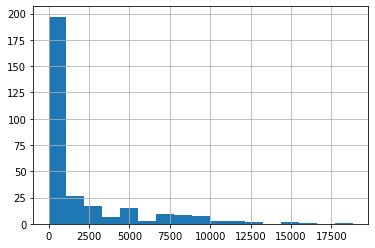

In [131]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_buy_df["agent"].nunique())))

<AxesSubplot:>

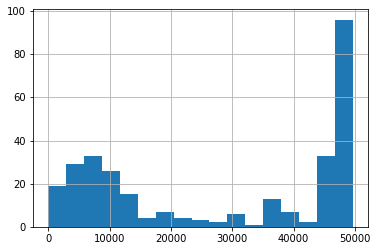

In [132]:
cannot_sell_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_sell_df["agent"].nunique())))

In [133]:
cannot_sell_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).argmax()

3

In [134]:
cannot_buy_df.set_index(["tick", "agent"]).max(axis=1).describe()

count    600300.000000
mean        283.182992
std        1229.161599
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18825.000000
dtype: float64

In [135]:
cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).describe()

count    600300.000000
mean      12298.465392
std       14550.249521
min           0.000000
25%         300.000000
50%        4550.000000
75%       22475.000000
max       49650.000000
dtype: float64

What product was being sold by the agent with the largest cannot sell ticks?

In [136]:
agent_goods_df.loc[cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).index[cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).argmax()][1]]

0     0.0
1     0.0
2     0.0
3     1.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
Name: 3, dtype: float64

# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [137]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [138]:
costs.describe()

count    3.000000e+02
mean     1.459587e+06
std      6.316564e+06
min      4.096374e+04
25%      1.702684e+05
50%      2.791451e+05
75%      4.159753e+05
max      6.499186e+07
Name: value, dtype: float64

In [139]:
revenue.describe()

count    3.000000e+02
mean     2.016273e+06
std      8.703304e+06
min      2.909138e+03
25%      1.763648e+05
50%      3.199945e+05
75%      6.666886e+05
max      9.530265e+07
Name: value, dtype: float64

Profit (without accounting for inventory value):

In [140]:
(revenue-costs).describe()

count    3.000000e+02
mean     5.566855e+05
std      3.563670e+06
min     -5.684031e+06
25%     -3.435489e+03
50%      5.562995e+03
75%      1.887968e+05
max      5.012435e+07
Name: value, dtype: float64

<AxesSubplot:>

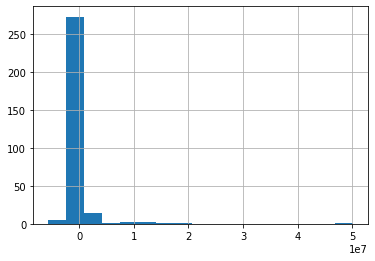

In [141]:
((revenue - costs)).hist(bins=int(np.sqrt(revenue.shape[0])))

How much value is sitting in inventory?

In [142]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

count    3.000000e+02
mean     2.446756e+05
std      1.588869e+06
min      0.000000e+00
25%      5.158354e+03
50%      1.635433e+04
75%      2.692933e+04
max      1.698914e+07
dtype: float64

In [143]:
revenue.mean() - costs.mean()

556685.4715557969

In [144]:
value_of_goods_on_hand.mean()/revenue.mean()

0.12135043867290485

Profit (accounting for value of goods on hand):

In [145]:
((revenue - costs) + value_of_goods_on_hand).describe()

count    3.000000e+02
mean     8.013610e+05
std      4.530439e+06
min     -2.335236e+06
25%      5.311530e+03
50%      2.461908e+04
75%      2.278614e+05
max      6.503270e+07
dtype: float64

<AxesSubplot:>

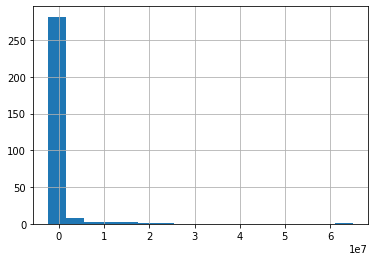

In [146]:
((revenue - costs) + value_of_goods_on_hand).hist(bins=int(np.sqrt(revenue.shape[0])))

## Further Investigation

### Profit by Product

In [147]:
revenue-costs

seller
0       10603.867155
1         436.592038
2       -3578.081205
3       -3431.656149
4       21175.707367
           ...      
295    319083.749193
296    743108.084162
297      2146.998421
298    149425.019493
299       769.557035
Name: value, Length: 300, dtype: float64

In [148]:
agent_results = pd.DataFrame({"product":agent_goods_df.idxmax(axis=1), "profit":revenue-costs})
profit_by_product = agent_results.groupby("product")["profit"].describe().sort_values("mean")
profit_by_product["sem"] = agent_results.groupby("product").sem()
profit_by_product = profit_by_product.sort_values("mean", ascending=False)
profit_by_product

,count,mean,std,min,25%,50%,75%,max,sem
product,,,,,,,,,
21,2.0,2.363651e+07,3.745946e+07,-2.851325e+06,1.039259e+07,2.363651e+07,3.688043e+07,5.012435e+07,2.648784e+07
25,1.0,1.964090e+07,NaN,1.964090e+07,1.964090e+07,1.964090e+07,1.964090e+07,1.964090e+07,NaN
23,1.0,1.227844e+07,NaN,1.227844e+07,1.227844e+07,1.227844e+07,1.227844e+07,1.227844e+07,NaN
8,3.0,9.013096e+06,5.538279e+06,2.857357e+06,6.723714e+06,1.059007e+07,1.209097e+07,1.359186e+07,3.197527e+06
22,1.0,6.473406e+06,NaN,6.473406e+06,6.473406e+06,6.473406e+06,6.473406e+06,6.473406e+06,NaN
24,2.0,2.457258e+06,1.151352e+07,-5.684031e+06,-1.613387e+06,2.457258e+06,6.527902e+06,1.059855e+07,8.141289e+06
5,20.0,1.460063e+06,3.312010e+06,4.068306e+05,6.037431e+05,6.718105e+05,8.153636e+05,1.549194e+07,7.405879e+05
11,7.0,1.133729e+06,1.176986e+06,7.500522e+04,2.093738e+05,3.190837e+05,2.203103e+06,2.717061e+06,4.448587e+05
17,4.0,1.003546e+06,9.042938e+05,-2.039034e+05,6.820315e+05,1.127950e+06,1.449464e+06,1.962186e+06,4.521469e+05


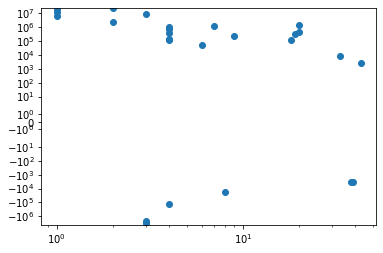

In [149]:
plt.scatter(profit_by_product["count"], profit_by_product["mean"])
plt.xscale("log")
plt.yscale("symlog")

<BarContainer object of 26 artists>

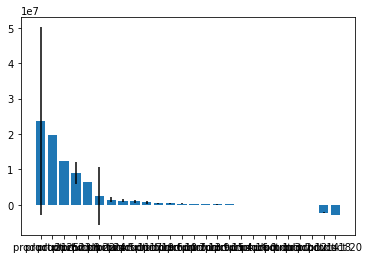

In [150]:
xvals = np.arange(len(profit_by_product))
width = 0.2
plt.bar(list(map(lambda x: f'product {x}', profit_by_product.index.to_list())), profit_by_product["mean"], yerr=profit_by_product["sem"].fillna(0))
#ax2 = plt.twinx()
#ax2.bar(xvals + width, profit_by_product["std"], width=width)

### Who Made a Profit?

In [151]:
print(len(np.where(((revenue - costs)) > 0)[0]))
np.where(((revenue - costs)) > 0)

184


(array([  0,   1,   4,   5,   6,   7,   8,   9,  10,  11,  15,  16,  19,
         22,  23,  25,  27,  28,  30,  33,  34,  36,  37,  38,  39,  40,
         42,  43,  44,  45,  46,  47,  48,  51,  52,  54,  55,  56,  58,
         59,  61,  62,  64,  65,  66,  69,  70,  71,  72,  73,  74,  75,
         77,  78,  79,  81,  85,  87,  88,  91,  92,  93,  94,  95,  97,
         99, 101, 102, 103, 104, 105, 107, 108, 109, 111, 112, 113, 114,
        116, 117, 118, 120, 121, 124, 125, 127, 129, 131, 132, 134, 136,
        138, 140, 141, 145, 147, 149, 151, 153, 156, 158, 159, 160, 163,
        167, 168, 169, 171, 172, 173, 175, 179, 183, 186, 187, 188, 189,
        190, 194, 195, 196, 201, 202, 205, 207, 208, 212, 214, 216, 220,
        221, 223, 224, 226, 227, 228, 229, 231, 233, 234, 235, 236, 237,
        238, 240, 241, 244, 245, 246, 247, 248, 249, 250, 251, 253, 254,
        255, 256, 259, 260, 261, 264, 265, 266, 267, 268, 269, 271, 273,
        274, 275, 277, 279, 280, 283, 285, 289, 290

In [152]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) > 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) > 0)

250


(array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  15,  16,
         17,  19,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  33,
         34,  35,  36,  37,  38,  39,  40,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  61,  62,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  81,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121,
        123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137,
        138, 140, 141, 142, 145, 146, 147, 148, 149, 150, 151, 153, 154,
        155, 156, 158, 159, 160, 162, 163, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 178, 179, 180, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 199, 200,
        201, 202, 203, 205, 206, 207, 208, 211, 212

In [153]:
revenue[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False).head(10)

seller
88     9.530265e+07
202    7.430417e+07
24     5.930783e+07
25     3.588337e+07
22     3.290734e+07
23     3.206939e+07
117    2.892635e+07
8      2.267778e+07
27     1.852272e+07
194    1.496244e+07
Name: value, dtype: float64

In [154]:
costs[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False)

buyer
24     6.499186e+07
202    6.370562e+07
88     4.517830e+07
22     2.643393e+07
23     1.979095e+07
           ...     
125    7.018744e+04
42     6.795012e+04
140    6.666821e+04
203    5.390801e+04
16     4.096374e+04
Name: value, Length: 250, dtype: float64

top profit takers

In [155]:
(revenue-costs).sort_values(ascending=False).head(20)

seller
88     5.012435e+07
25     1.964090e+07
27     1.549194e+07
117    1.359186e+07
23     1.227844e+07
202    1.059855e+07
8      1.059007e+07
22     6.473406e+06
172    3.499266e+06
223    2.857357e+06
145    2.717061e+06
151    2.282154e+06
194    2.149055e+06
11     2.124051e+06
253    1.980271e+06
30     1.962186e+06
129    1.325780e+06
221    1.278557e+06
48     1.200587e+06
173    1.036132e+06
Name: value, dtype: float64

In [156]:
agent_goods_df.loc[(revenue-costs).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

88     21
25     25
27      5
117     8
23     23
202    24
8       8
22     22
172     6
223     8
145    11
151    11
194    19
11     11
253     7
30     17
129     5
221    17
48      5
173     5
dtype: int64

Taking into account value of goods on hand:

In [157]:
(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20)

seller
88     6.503270e+07
202    2.448797e+07
25     1.969106e+07
27     1.549602e+07
23     1.520490e+07
117    1.359636e+07
24     1.130511e+07
8      1.059395e+07
194    7.980141e+06
22     6.923177e+06
172    3.517509e+06
223    2.862483e+06
145    2.792323e+06
151    2.388287e+06
11     2.228512e+06
30     2.135218e+06
253    2.007047e+06
21     1.865535e+06
221    1.622826e+06
129    1.434896e+06
dtype: float64

In [158]:
agent_goods_df.loc[(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

88     21
202    24
25     25
27      5
23     23
117     8
24     24
8       8
194    19
22     22
172     6
223     8
145    11
151    11
11     11
30     17
253     7
21     21
221    17
129     5
dtype: int64

### Who Made a Loss?

And selling what products?

In [159]:
print(len(np.where(((revenue - costs)) < 0)[0]))
np.where(((revenue - costs)) < 0)

116


(array([  2,   3,  12,  13,  14,  17,  18,  20,  21,  24,  26,  29,  31,
         32,  35,  41,  49,  50,  53,  57,  60,  63,  67,  68,  76,  80,
         82,  83,  84,  86,  89,  90,  96,  98, 100, 106, 110, 115, 119,
        122, 123, 126, 128, 130, 133, 135, 137, 139, 142, 143, 144, 146,
        148, 150, 152, 154, 155, 157, 161, 162, 164, 165, 166, 170, 174,
        176, 177, 178, 180, 181, 182, 184, 185, 191, 192, 193, 197, 198,
        199, 200, 203, 204, 206, 209, 210, 211, 213, 215, 217, 218, 219,
        222, 225, 230, 232, 239, 242, 243, 252, 257, 258, 262, 263, 270,
        272, 276, 278, 281, 282, 284, 286, 287, 288, 291, 293, 294]),)

In [160]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) < 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

50


(array([  3,  12,  13,  14,  18,  20,  31,  32,  41,  57,  60,  63,  80,
         82,  83,  84, 100, 119, 122, 130, 135, 139, 143, 144, 152, 157,
        161, 164, 177, 181, 193, 198, 204, 209, 210, 215, 217, 219, 222,
        225, 230, 232, 243, 252, 263, 270, 284, 287, 288, 294]),)

In [161]:
(revenue-costs).sort_values(ascending=True).head(20)

seller
24    -5.684031e+06
215   -2.861394e+06
20    -2.859688e+06
152   -2.856807e+06
21    -2.851325e+06
18    -2.220832e+06
144   -2.220656e+06
63    -2.135453e+06
17    -2.039034e+05
35    -1.739952e+05
100   -1.714488e+05
130   -1.714345e+05
82    -1.684253e+05
232   -1.511195e+05
115   -1.213920e+05
83    -1.208744e+05
31    -5.333689e+04
164   -5.233334e+04
288   -4.814855e+04
209   -4.524536e+04
Name: value, dtype: float64

In [162]:
agent_goods_df[((revenue - costs)) < 0].idxmax(axis=1).head(20)

2      2
3      3
12    12
13    13
14    14
17    17
18    18
20    20
21    21
24    24
26     2
29     1
31    12
32     3
35    19
41     3
49     0
50     2
53     2
57     3
dtype: int64

In [163]:
(revenue-costs + value_of_goods_on_hand).sort_values(ascending=True).head(20)

seller
152   -2.335236e+06
20    -2.308449e+06
215   -2.141707e+06
18    -1.822038e+06
144   -1.787318e+06
63    -1.550169e+06
100   -1.582543e+05
130   -1.503830e+05
232   -1.266871e+05
83    -7.991281e+04
31    -4.121205e+04
288   -4.066963e+04
164   -3.920287e+04
12    -3.369446e+04
294   -2.986614e+04
82    -2.404175e+04
209   -1.684963e+04
14    -1.389473e+04
13    -1.191589e+04
284   -3.578508e+03
dtype: float64

In [164]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

3       3
12     12
13     13
14     14
18     18
20     20
31     12
32      3
41      3
57      3
60      3
63     18
80      3
82     15
83     13
84      3
100    14
119     3
122     3
130    14
135     3
139     3
143     3
144    18
152    20
157     3
161     3
164    12
177     3
181     3
193     3
198     3
204     3
209    13
210     3
215    20
217     3
219     3
222     3
225     3
230     3
232    14
243     3
252     3
263     3
270     3
284     2
287     3
288    12
294    12
dtype: int64

### Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [165]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

agent
0       10647.844971
1         513.322753
2       -3357.715563
3       -3216.285501
4       21175.707367
           ...      
295    319083.749193
296    743108.084162
297      2223.729136
298    149425.019493
299       846.287750
Name: balance, Length: 300, dtype: float64

<AxesSubplot:>

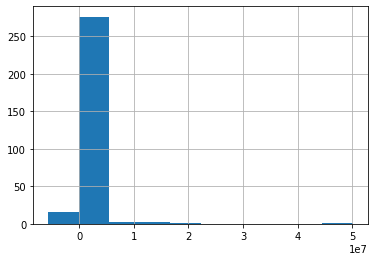

In [166]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

<AxesSubplot:>

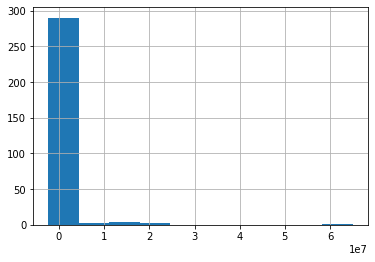

In [167]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

# Production Efficiency